# import previous models

In [77]:
import pandas as pd
import ast,json
import numpy as np
from pymatgen.core import Composition
import CompositionDeformer as compd
from tensorflow.keras.utils import to_categorical
print("hello new materials")
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras.models import clone_model
from IPython.display import Image
import tqdm

from tensorflow.keras.layers import Activation, Conv2D, Dense, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential, Model

hello new materials


In [ ]:
def reset_weights(model,weights=None):
    for layer in model.layers:
        print("---------------")
        print(layer)
        if isinstance(layer, tf.keras.Model): #if you're using a model as a layer
            reset_weights(layer) #apply function recursively
            continue
        if hasattr(layer, 'cell'):
            init_container = layer.cell
        else:
            init_container = layer

        for key, initializer in init_container.__dict__.items():
            if ("kernel_initializer" or "recurrent_initializer") not in key: #is this item an initializer?
                  continue #if no, skip it
            else:
                print("key:")
                print(key)
                print("initializer:")
                print(initializer)
                weights = layer.get_weights()
                weights = [initializer(w.shape, w.dtype) for w in weights] 
                layer.set_weights(weights)

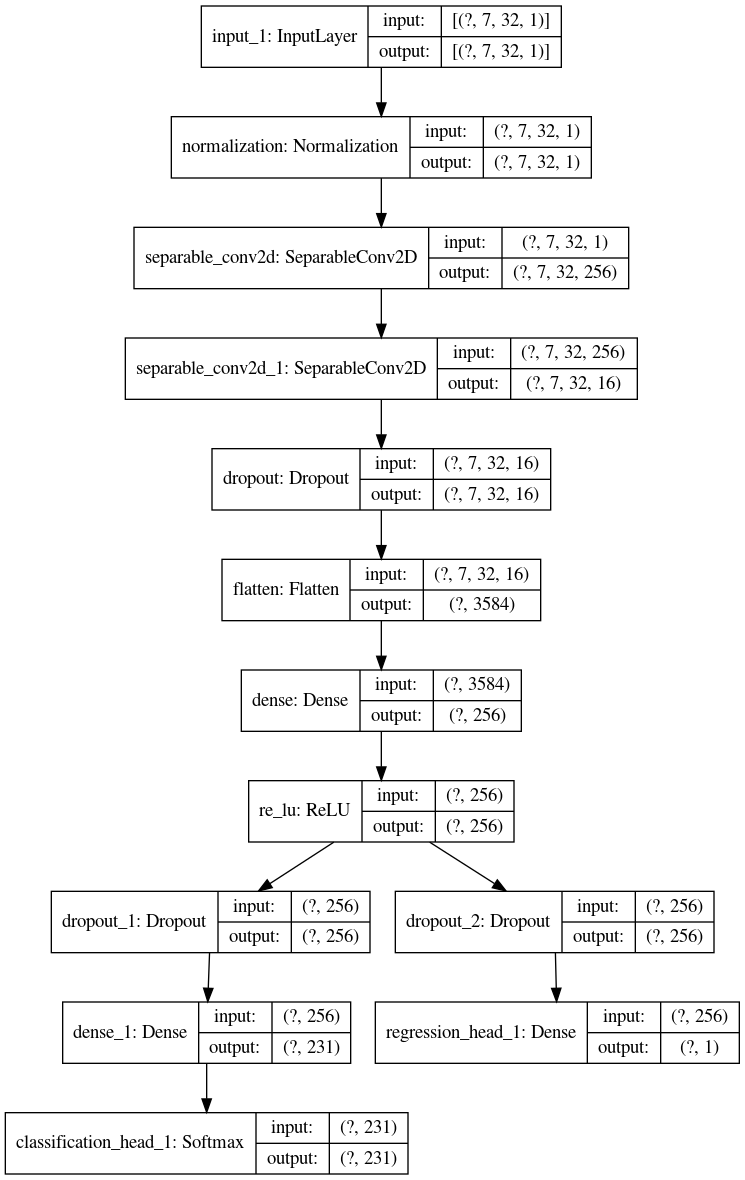

In [75]:
#load models and visualize model layers
loaded_model= load_model("./models/release/200827_ES_custom_50ep.h5")
plot_model(loaded_model, to_file='./loaded_model.png', show_layer_names=True, show_shapes=True)
display(Image('loaded_model.png'))

# import source data

In [7]:
# import materials project database
seeddata = pd.read_csv("./database/materials_project/mp_all_data.csv",index_col=0)
# add 1d periodic table array and normalized magnifications
normalized_magnifications = []
composition_names = []
normalized_compositions = []

for unit in tqdm.tqdm(seeddata["unit_cell_formula"]):
    compdict = ast.literal_eval(unit)
    composition_name = ""
    for item in compdict.items():
        composition_name += item[0] + str(item[1])
    #print(f"composition name: {composition_name}")
    composition_names.append(composition_name)
    #組成の規格化
    comp = Composition(composition_name)
    normalized_compositions.append(comp.fractional_composition.reduced_formula)
    ratio_list = {}
    for el,ratio in comp.fractional_composition.as_dict().items():
        ratio_list[el] = ratio
    #規格化後の倍率を取得
    normalized_magnification = [ratio_list[key]/compdict[key] for key in compdict.keys()][0]
    #print(f"normalized magnification: {normalized_magnification}")
    normalized_magnifications.append(normalized_magnification)
    
print(seeddata.keys())
##エネルギーを規格化しseeddataに追加
energy_array = np.array(seeddata["energy"],dtype=np.float32)
magnifications_array = np.array(normalized_magnifications,dtype=np.float32)
normalized_energy = energy_array*magnifications_array
seeddata["normalized_energy"] = normalized_energy
##normalized_magnificationを追記
seeddata["normalized_magnification"] = normalized_magnifications
##compositionを追記
seeddata["composition_name"] = composition_names
##normalized_compositionsを追記
seeddata["normalized_composition"] = normalized_compositions
print(seeddata.keys())

#重複する組成データのうちエネルギーが最も低いもののみ残す
##エネルギー順に並び変え
sorted_seeddata = seeddata.sort_values(['normalized_composition','normalized_energy'])
print(sorted_seeddata.shape)
##重複した組成式のうち一番上（昇順なので一番上が最安定）のみ残して削除
dropped_seeddata = sorted_seeddata.drop_duplicates(keep='first',subset='normalized_composition')
print(dropped_seeddata.shape)

  4%|▍         | 5069/126356 [00:00<00:11, 10132.35it/s]/home/wshogo/.local/lib/python3.7/site-packages/pymatgen/core/periodic_table.py:426: UserWarning: No electronegativity for He. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  % self.symbol)
 26%|██▌       | 32541/126356 [00:03<00:09, 10127.12it/s]/home/wshogo/.local/lib/python3.7/site-packages/pymatgen/core/periodic_table.py:426: UserWarning: No electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  % self.symbol)
 50%|█████     | 63184/126356 [00:06<00:06, 10145.49it/s]/home/wshogo/.local/lib/python3.7/site-packages/pymatgen/core/periodic_table.py:426: UserWarning: No electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  % self.symbol)
100%|██████████| 126356/126356 [00:12<00:

Index(['pretty_formula', 'unit_cell_formula', 'energy', 'energy_per_atom',
       'band_gap', 'symmetry'],
      dtype='object')
Index(['pretty_formula', 'unit_cell_formula', 'energy', 'energy_per_atom',
       'band_gap', 'symmetry', 'normalized_energy', 'normalized_magnification',
       'composition_name', 'normalized_composition'],
      dtype='object')
(126356, 10)
(89465, 10)


In [8]:
#拡張周期表表記の入力配列を作成
periodic_1d_arrays = []
for composition_name in tqdm.tqdm(dropped_seeddata['normalized_composition']):
    periodic_1d_arrays.append(compd.generate_extended_PT_from_composition(composition_name).get_1d_array())
#入力データを2次元マップに変換
X = np.array(periodic_1d_arrays, dtype = np.float32)
X = X.reshape((len(X),7,32))
print(X.shape)

##バンドギャップをnumpy配列化
band_gap_array = np.array(dropped_seeddata["band_gap"],dtype=np.float32)
##空間群をcategorical配列に変換
symmetry_category = to_categorical(dropped_seeddata["symmetry"])

100%|██████████| 89465/89465 [00:04<00:00, 19292.66it/s]

(89465, 7, 32)


In [9]:
#訓練用データセットに分ける
from sklearn.model_selection import train_test_split
#新規データとしてband gapを取得し訓練用とテスト用に分ける
X_train,X_test,bandgap_train,bandgap_test,symmetry_train,symmetry_test = train_test_split(X,band_gap_array,symmetry_category,test_size=0.1)
# X_train,X_test,energy_train,energy_test,symmetry_train,symmetry_test = train_test_split(X,dropped_seeddata["normalized_energy"],symmetry_category,test_size=0.1)

# transfer learning with new data

In [84]:
#model reconstruction
# すでにあるモデルの途中から新しいモデルを作る。

##レイヤー名の取得と切断レイヤーの選別
for i in [-1, -2, -3, -4, -5, -6, -7]:    
    layer = loaded_model.layers[i].output
    print(layer.name)
##残すベース部分のアウトプット層を取得
cut_output = loaded_model.layers[-7].output
##層を追加
fc1 = Dense(100, activation="relu")(cut_output)
fc2 = Dropout(rate=0.5)(fc1)
fc2._name = "dropout_end"
fc3 = Dense(1, activation="linear")(fc2)
##転移モデルを作成
transfered_model = Model(inputs=loaded_model.inputs, outputs=fc3)
##ベースの層の訓練を禁止
for i in range(6):
    transfered_model.layers[i].trainable = False
transfered_model.summary()

##訓練用モデルを構築
transfered_model.compile(loss="mse", optimizer="adam", metrics=["mae"])

regression_head_1/BiasAdd_2:0
classification_head_1/Softmax_2:0
dropout_2/cond_2/Identity:0
dense_1/BiasAdd_3:0
dropout_1/cond_2/Identity:0
re_lu/Relu_2:0
dense/BiasAdd_3:0
Model: "functional_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7, 32, 1)]        0         
_________________________________________________________________
normalization (Normalization (None, 7, 32, 1)          3         
_________________________________________________________________
separable_conv2d (SeparableC (None, 7, 32, 256)        561       
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 7, 32, 16)         16656     
_________________________________________________________________
dropout (Dropout)            (None, 7, 32, 16)         0         
_________________________________________________________________
flatten (Fla

In [85]:
#limit inputs
data_limit = 20000
limited_X = X_train[:data_limit]
validation_X = X_train[data_limit:]

limited_bandgap = bandgap_train[:data_limit]
validation_bandgap = bandgap_train[data_limit:]

transfered_history = transfered_model.fit(limited_X, limited_bandgap, epochs=100, validation_split=0.2)

Epoch 1/100
500/500 [==============================] - 2s 5ms/step - loss: 1.3888 - mae: 0.8034 - val_loss: 1.1109 - val_mae: 0.7118
Epoch 2/100
500/500 [==============================] - 3s 6ms/step - loss: 1.1867 - mae: 0.7182 - val_loss: 1.0234 - val_mae: 0.6806
Epoch 3/100
500/500 [==============================] - 3s 6ms/step - loss: 1.1154 - mae: 0.7005 - val_loss: 0.9998 - val_mae: 0.6776
Epoch 4/100
500/500 [==============================] - 3s 6ms/step - loss: 1.0926 - mae: 0.6980 - val_loss: 0.9548 - val_mae: 0.6627
Epoch 5/100
500/500 [==============================] - 3s 6ms/step - loss: 1.0827 - mae: 0.6984 - val_loss: 0.9783 - val_mae: 0.6651
Epoch 6/100
500/500 [==============================] - 3s 6ms/step - loss: 1.0625 - mae: 0.6957 - val_loss: 0.9600 - val_mae: 0.6597
Epoch 7/100
500/500 [==============================] - 3s 6ms/step - loss: 1.0460 - mae: 0.6891 - val_loss: 0.9568 - val_mae: 0.6636
Epoch 8/100
500/500 [==============================] - 3s 6ms/step - 

In [88]:
transfered_model.evaluate(validation_X, validation_bandgap)

1892/1892 [==============================] - 11s 6ms/step - loss: 0.8304 - mae: 0.6015


[0.8303993940353394, 0.6014753580093384]

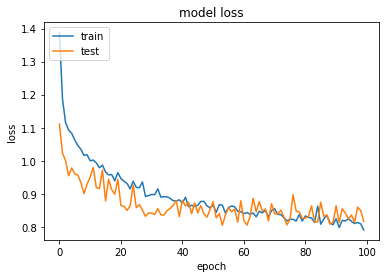

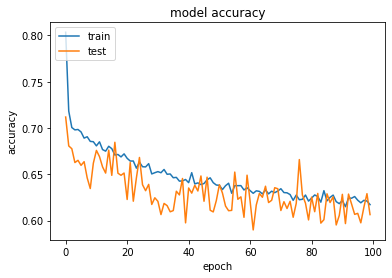

In [89]:
import matplotlib.pyplot as plt
# 損失値をグラフ表示
history = transfered_history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# 正解率をグラフ表示
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

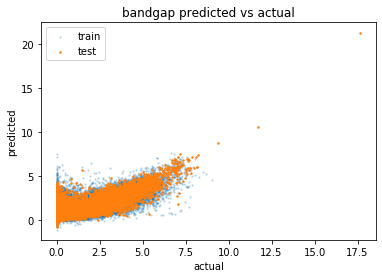

In [87]:
#予測値と実測値の描画
import matplotlib.pyplot as plt
#visualization of train and test prediction
## energy
predicted_bandgap_train = transfered_model.predict(limited_X)
predicted_bandgap_test = transfered_model.predict(validation_X)
plt.scatter(validation_bandgap,predicted_bandgap_test,alpha =0.2,s=2)
plt.scatter(limited_bandgap,predicted_bandgap_train,s=2)
plt.title('bandgap predicted vs actual')
# plt.xlim(-12.5,0)
# plt.ylim(-12.5,0)
plt.ylabel('predicted')
plt.xlabel('actual')
plt.legend(['train', 'test'], loc='upper left')
plt.show()